In [4]:
import torch
import numpy as np 
from gpytorch.kernels import ScaleKernel
from abc import ABC, abstractmethod
import gpytorch
import os
import sys

# Data path setup
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from util  import train, eval, plot_gpr_results, memory_dump, fetch_uci_dataset
import sys
from plotting import plot_gp_simple,plot_gp_sample,plot_gp_simple_regions


%load_ext autoreload
%autoreload 2
device="cuda:0"
global_dtype=torch.float32
np.random.seed(42)
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), 
                  n_train=100, n_test=100, noise_std=0.1, 
                  device='cuda:0', dtype=torch.float64):
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)  # No noise added to test data
    
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

def true_function(x):
    return torch.sin(2 * x) + torch.cos(3 * x)
train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5,5), dtype=global_dtype)

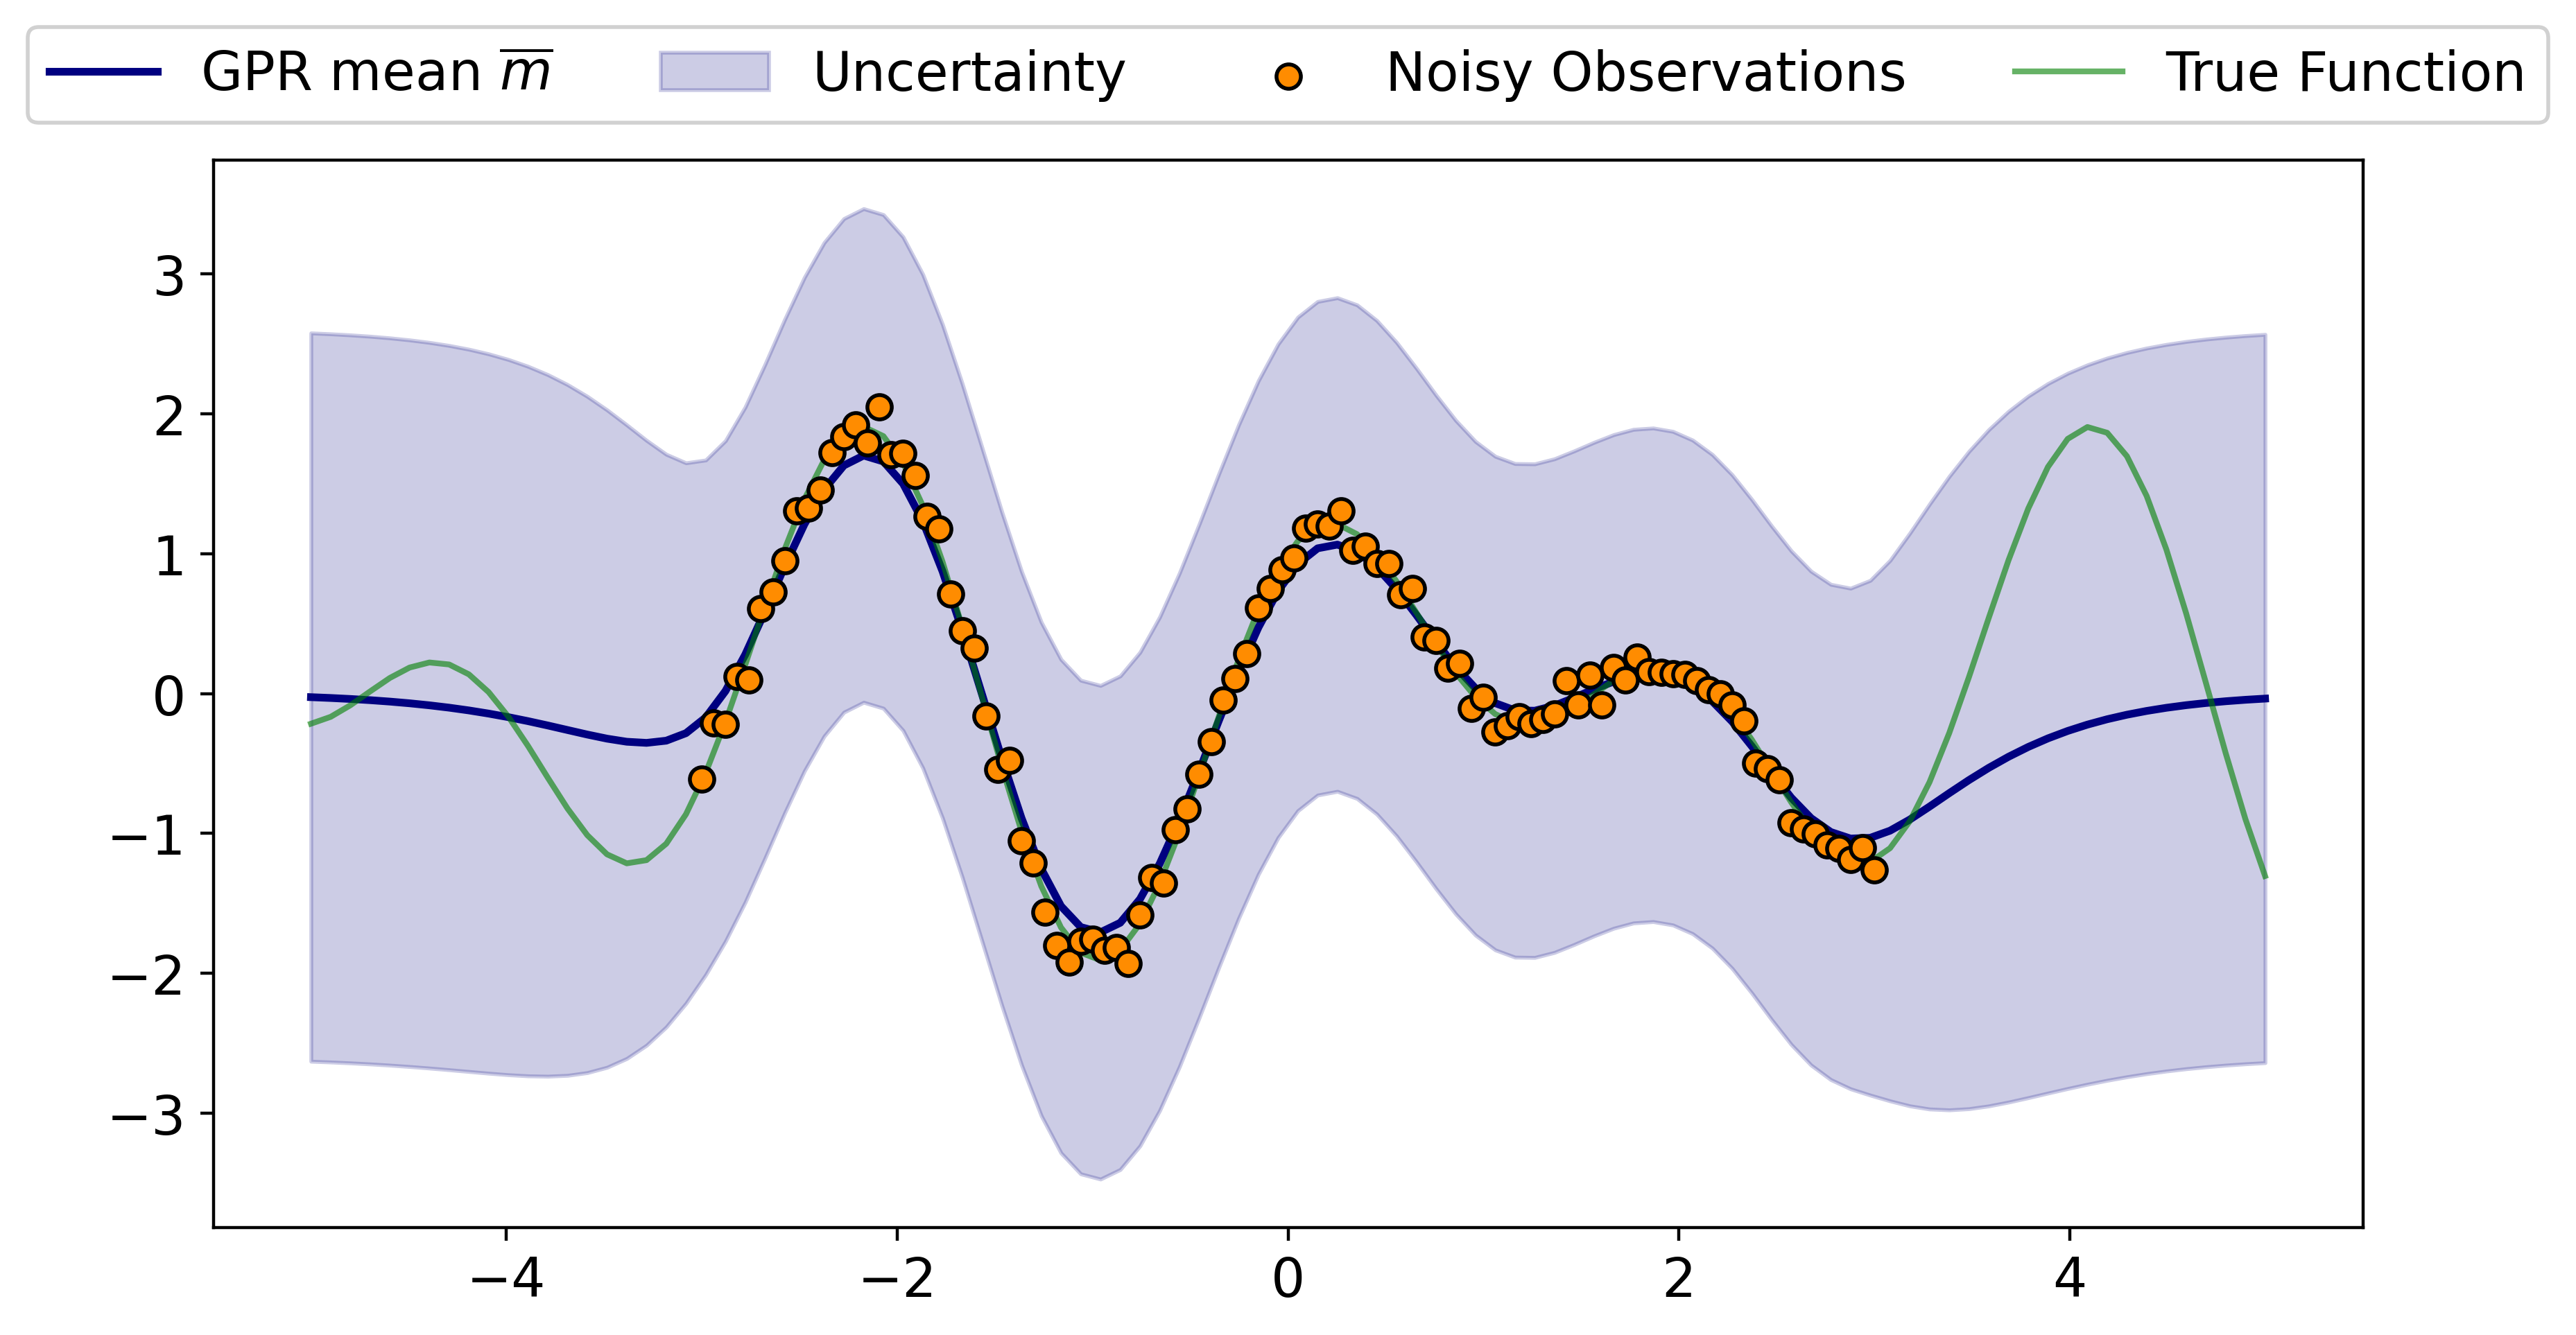

In [6]:
import torch
import gpytorch
from gpytorch.priors import GammaPrior

device = "cuda:0"
global_dtype = torch.float32
train_x = train_x.cuda()
train_y = train_y.cuda()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=1.5)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood.noise_covar.register_prior("noise_prior", GammaPrior(2.0, 0.15), "noise")

model = ExactGPModel(train_x, train_y, likelihood).to(device)

model.train()
likelihood.train()
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

mean = observed_pred.mean.cpu()
lower, upper = observed_pred.confidence_region()

plot_gp_simple_regions(train_x.cpu(), train_y.cpu(), test_x.cpu(),test_y.cpu(), observed_pred.mean.cpu(), lower.cpu(), upper.cpu())

In [7]:
import torch
import gpytorch
from gpytorch.priors import GammaPrior

device = "cuda:0"
global_dtype = torch.float32

# Assume train_x, train_y, test_x, test_y are already generated and on CPU.
# Move training data to CUDA.
train_x = train_x.cuda()
train_y = train_y.cuda()

# Define the Exact GP model using a Matérn 3/2 kernel.
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=1.5)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the Gaussian likelihood and register a Gamma prior on its noise.
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood.noise_covar.register_prior("noise_prior", GammaPrior(2.0, 0.15), "noise")

# Initialize the model and move it to CUDA.
model = ExactGPModel(train_x, train_y, likelihood).to(device)

# Set the model and likelihood into training mode.
model.train()
likelihood.train()

# Set up the optimizer and marginal log likelihood.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Perform 100 training steps.
training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f"Iteration {i}/{training_iter} - Loss: {loss.item():.3f}")
    optimizer.step()

# Set into evaluation mode for inference.
model.eval()
likelihood.eval()

# Evaluate on test data (assuming test_x is on CPU; if not, move it).
test_x = test_x.cuda()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Extract predictions and move back to CPU.
mean = observed_pred.mean.cpu()
lower, upper = observed_pred.confidence_region()
lower = lower.cpu()
upper = upper.cpu()

# Move test_y to CPU if needed.
test_y = test_y.cpu()

# Plot using your custom plotting function.
plot_gp_simple_regions(train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y, mean, lower, upper)

ImportError: cannot import name 'plot_gp_simple_regions' from 'util' (c:\Users\fredw\chris\Research\randomGP2\code\util.py)